In [ ]:
# @title
# -*- coding: utf-8 -*-
"""
BR‑AsPavDam – fine‑tune a partir do peso RDDC IMSC
--------------------------------------------------
• 5 classes  : Fissures, Shoving, Ravelling, Pothole, Patch
• Oversample : garante ≥ 300 bboxes p/ {Fissures, Shoving, Ravelling}
• Treino     : 100 épocas · batch 16 · imgsz 640 · cos_lr
• Validação  : --conf 0.1
"""
import subprocess, yaml, random, cv2, os, shutil, textwrap
from pathlib import Path
from shutil  import copy2
# ---------------------------------------------------------------------
# 0) (Re)monta o Google Drive
# ---------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ---------------------------------------------------------------------
# 1) Caminhos principais
# ---------------------------------------------------------------------
ROOT     = Path('/content/drive/MyDrive/Colab Notebooks/Br-AsPavDam')
IMG_TR   = ROOT/'images/train'
LBL_TR   = ROOT/'labels/train'

PRET_W   = ROOT/'rddc2020/yolov5/weights/IMSC/last_100_100_640_16.pt'
CFG_DATA = ROOT/'config.yaml'
HYP      = ROOT/'hyp_ftune_final.yaml'

YOLO_DIR = Path('/content/yolov5')            # repositório YOLOv5
TRAIN_PY = YOLO_DIR/'train.py'
DETECT_PY= YOLO_DIR/'detect.py'

RUNS     = ROOT/'runs/train'
RUN_NAME = 'br-aspavdam_new_labels'
RUN_DIR  = RUNS/RUN_NAME

NAMES     = ['Fissures','Shoving','Ravelling','Pothole','Patch']
TARGET_MIN= 300
AUG_ID    = 0

# ---------------------------------------------------------------------
# 2) Helpers
# ---------------------------------------------------------------------
def run(cmd, desc, cwd=None):
    print(f'\n🛠️ {desc}\n' + '─'*60)
    p = subprocess.run(cmd, text=True, capture_output=True, cwd=cwd)
    print(p.stdout); print(p.stderr)
    if p.returncode:
        raise RuntimeError(f'Erro {p.returncode}: {" ".join(cmd)}')

def count_boxes(lbl_dir):
    cnt = {n:0 for n in NAMES}
    for txt in Path(lbl_dir).glob('*.txt'):
        for ln in open(txt):
            cls = int(ln.split()[0])
            if cls < len(NAMES):
                cnt[NAMES[cls]] += 1
    return cnt

def simple_aug(img):
    if random.random()<0.5:
        img = cv2.flip(img, 1)
    if random.random()<0.5:
        h,w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w/2,h/2), random.uniform(-5,5), 1)
        img = cv2.warpAffine(img, M, (w,h),
                             borderMode=cv2.BORDER_REFLECT101)
    if random.random()<0.5:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype('float32')
        hsv[...,2] *= random.uniform(0.9,1.1)
        img  = cv2.cvtColor(hsv.clip(0,255).astype('uint8'),
                            cv2.COLOR_HSV2BGR)
    return img

# ---------------------------------------------------------------------
# 3) Confere/atualiza config.yaml (5 classes)
# ---------------------------------------------------------------------
cfg_ok = False
if CFG_DATA.exists():
    try:
        data = yaml.safe_load(open(CFG_DATA))
        cfg_ok = (data.get('names') == NAMES and
                  data.get('path', '').endswith('Br-AsPavDam'))
    except Exception:
        pass

if not cfg_ok:
    print('⚙️  Gravando config.yaml com as 5 classes corretas …')
    yaml.safe_dump({
        'path' : str(ROOT),
        'train': 'images/train',
        'val'  : 'images/val',
        'names': {i:n for i,n in enumerate(NAMES)}
    }, open(CFG_DATA,'w'))

# ---------------------------------------------------------------------
# 4) Oversampling (apenas classes 0‑2)
# ---------------------------------------------------------------------
print('📊 Antes do oversampling:', count_boxes(LBL_TR))
for cls_idx in (0,1,2):
    need = TARGET_MIN - count_boxes(LBL_TR)[NAMES[cls_idx]]
    if need <= 0:
        print(f'✔️ {NAMES[cls_idx]} já ≥{TARGET_MIN} (skip)')
        continue

    cand = [p for p in LBL_TR.glob('*.txt')
            if any(int(l.split()[0])==cls_idx for l in open(p))]
    if not cand:
        print(f'⚠️  Nenhum exemplo de {NAMES[cls_idx]} encontrado.')
        continue

    print(f'🔄 Gerando {need} novas bboxes p/ {NAMES[cls_idx]} …')
    while need > 0:
        src_lbl = random.choice(cand)
        src_img = IMG_TR/(src_lbl.stem + '.png')
        if not src_img.exists(): continue

        aug_img = simple_aug(cv2.imread(str(src_img)))
        out_img = IMG_TR/f'{src_img.stem}_aug{AUG_ID}.png'
        out_lbl = LBL_TR/f'{src_lbl.stem}_aug{AUG_ID}.txt'
        AUG_ID += 1

        cv2.imwrite(str(out_img), aug_img)
        copy2(src_lbl, out_lbl)

        need -= sum(1 for l in open(src_lbl)
                    if int(l.split()[0])==cls_idx)
print('📊 Depois do oversampling:', count_boxes(LBL_TR))

# ---------------------------------------------------------------------
# 5) Hiper‑parâmetros
# ---------------------------------------------------------------------
hyp = yaml.safe_load(open(HYP)) if HYP.exists() else {}
hyp.pop('freeze_layers', None)
hyp['cos_lr'] = True
yaml.safe_dump(hyp, open(HYP,'w'))
print('✅  hyper‑parâmetros salvos →', HYP)

# ---------------------------------------------------------------------
# 6) YOLOv5: clona limpo se não existir
# ---------------------------------------------------------------------
if not YOLO_DIR.exists():
    run(['git','clone','https://github.com/ultralytics/yolov5', str(YOLO_DIR)],
        'Clonando YOLOv5')
run(['pip','install','-U','ultralytics'], 'Instalando/atualizando ultralytics')

# ---------------------------------------------------------------------
# 7) Sanity checks
# ---------------------------------------------------------------------
if not PRET_W.exists():
    raise FileNotFoundError(f'Peso não encontrado:\n  {PRET_W}')

# ---------------------------------------------------------------------
# 8) Treino
# ---------------------------------------------------------------------
run([
    'python', str(TRAIN_PY),
    '--img', '640',
    '--batch', '16',
    '--epochs', '100',
    '--data', str(CFG_DATA),
    '--weights', str(PRET_W),
    '--hyp', str(HYP),
    '--project', str(RUNS),
    '--name', RUN_NAME,
    '--exist-ok',
    '--patience','20'
], 'Treinando modelo', cwd=str(YOLO_DIR))

# ---------------------------------------------------------------------
# 9) Validação (conf 0.1)
# ---------------------------------------------------------------------
best = RUN_DIR/'weights/best.pt'
if best.exists():
    run([
        'python', str(DETECT_PY),
        '--weights', str(best),
        '--img', '640',
        '--conf','0.1',
        '--source', str(ROOT/'images/val'),
        '--project', str(ROOT/'results'),
        '--name', RUN_NAME,
        '--exist-ok',
        '--save-txt','--save-conf'
    ], 'Validação (conf=0.1)', cwd=str(YOLO_DIR))
else:
    print('⚠️  best.pt não encontrado — verifique o treino.')

print('\n✅  Pipeline completo!')


A saída de streaming foi truncada nas últimas 5000 linhas.
      97/99      16.2G    0.01921    0.02396    0.00402         95        640:  36%|███▋      | 120/329 [01:36<02:30,  1.39it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):

      97/99      16.2G     0.0192    0.02392   0.004009         80        640:  36%|███▋      | 120/329 [01:37<02:30,  1.39it/s]
      97/99      16.2G     0.0192    0.02392   0.004009         80        640:  37%|███▋      | 121/329 [01:37<02:28,  1.40it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):

      97/99      16.2G    0.01915    0.02386   0.004006         88        640:  37%|███▋      | 121/329 [01:37<02:28,  1.40it/s]
      97/99      16.2G    0.01915    0.02386 

In [ ]:
## montar o drive

drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
##clona o yolov5

!git clone https://github.com/ultralytics/yolov5 /content/yolov5
%cd /content/yolov5
!pip install -qr requirements.txt  # instala dependências

Cloning into '/content/yolov5'...
remote: Enumerating objects: 17577, done.
remote: Total 17577 (delta 0), reused 0 (delta 0), pack-reused 17577 (from 1)
Receiving objects: 100% (17577/17577), 16.85 MiB | 21.20 MiB/s, done.
Resolving deltas: 100% (11973/11973), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00


In [ ]:
# @title
##roda a validação

!python val.py \
  --weights /content/drive/MyDrive/Colab\ Notebooks/Br-AsPavDam/runs/train/br-aspavdam_new_labels/weights/best.pt \
  --data    /content/drive/MyDrive/Colab\ Notebooks/Br-AsPavDam/config.yaml \
  --img 640 \
  --save-json \
  --project /content/drive/MyDrive/Colab\ Notebooks/Br-AsPavDam/runs/val_repro \
  --name br-aspavdam_val_json \
  --exist-ok

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
val: data=/content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/config.yaml, weights=['/content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/runs/train/br-aspavdam_new_labels/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=/content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/runs/val_repro, name=br-aspavdam_val_json, exist_ok=True, half=False, dnn=False
YOLOv5 🚀 v7.0-432-g725b922e Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)

Fusing layers... 
Model summary: 362 layers, 88417530

Classes carregadas: ['Fissures', 'Shoving', 'Ravelling', 'Pothole', 'Patch'] + Background


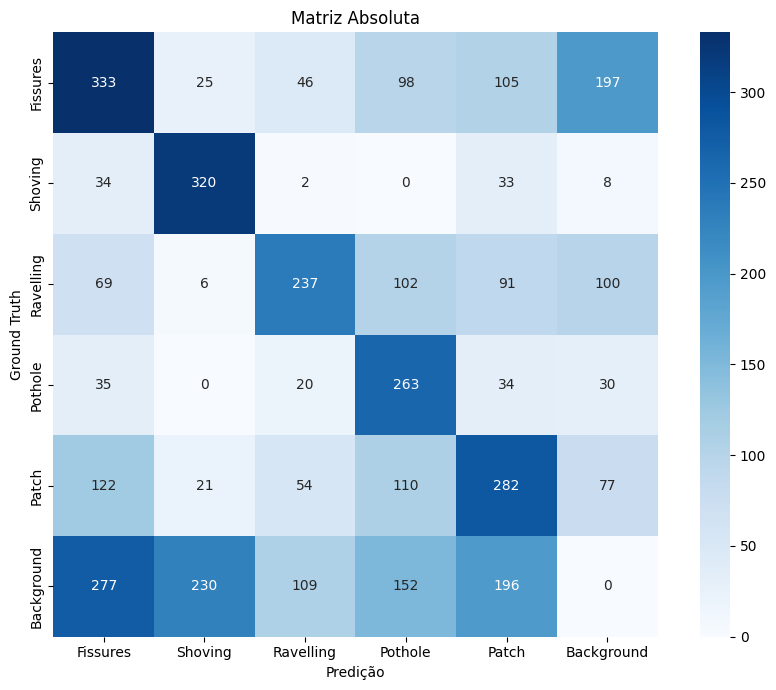

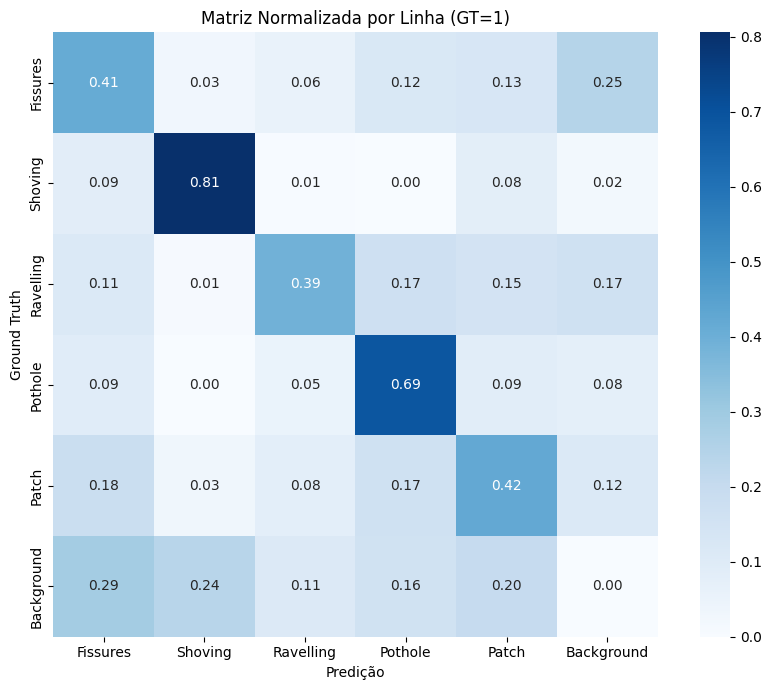

Arquivos salvos em: /content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/runs/confusion_clean


In [ ]:
# @title
# MATRIZ DE CONFUSÃO COCO
import yaml, json, cv2, numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
ROOT      = Path('/content/drive/MyDrive/Colab Notebooks/Br-AsPavDam')
VAL_IMG   = ROOT/'images/val'
VAL_LBL   = ROOT/'labels/val'
VAL_RUN   = ROOT/'runs/val_repro/br-aspavdam_val_json'
PRED_JSON = VAL_RUN/'best_predictions.json'
CFG_YAML  = ROOT/'config.yaml'

CONF_VIS = 0.25   # limiar de confiança só p/ matriz
IOU_THR  = 0.5    # limiar de IoU p/ match
OUT_DIR  = ROOT/'runs/confusion_clean'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------- CLASSES ----------
with open(CFG_YAML) as f:
    data_cfg = yaml.safe_load(f)
names = [data_cfg['names'][i] for i in range(len(data_cfg['names']))]
BG = len(names)   # índice para background
print("Classes carregadas:", names, "+ Background")

# ---------- HELPERS ----------
def yolo_to_xyxy(xc,yc,w,h,W,H):
    return [(xc-w/2)*W, (yc-h/2)*H, (xc+w/2)*W, (yc+h/2)*H]

def iou_xyxy(a,b):
    ax1,ay1,ax2,ay2 = a; bx1,by1,bx2,by2 = b
    ix1,iy1 = max(ax1,bx1), max(ay1,by1)
    ix2,iy2 = min(ax2,bx2), min(ay2,by2)
    iw,ih   = max(0, ix2-ix1), max(0, iy2-iy1)
    inter   = iw*ih
    area_a  = max(0,ax2-ax1)*max(0,ay2-ay1)
    area_b  = max(0,bx2-bx1)*max(0,by2-by1)
    union   = area_a + area_b - inter
    return inter/union if union>0 else 0.0

def load_gt(lbl_path,W,H):
    gts=[]
    if not lbl_path.exists(): return gts
    for ln in open(lbl_path):
        parts=ln.strip().split()
        if not parts: continue
        cls=int(parts[0]); xc,yc,w,h=map(float,parts[1:5])
        box=yolo_to_xyxy(xc,yc,w,h,W,H)
        gts.append((cls,box))
    return gts

# ---------- LOAD PREDICTIONS ----------
pred_all=json.load(open(PRED_JSON))
val_files=sorted([p.name for p in VAL_IMG.glob('*.*')])
pred_by_file={fn:[] for fn in val_files}

for p in pred_all:
    if p['score'] < CONF_VIS:
        continue
    img_id = str(p['image_id'])
    # procura arquivo cujo stem bate com o image_id
    matches = [f for f in val_files if Path(f).stem == img_id]
    if not matches:
        continue
    fn = matches[0]
    x,y,w,h = p['bbox']
    box = [x,y,x+w,y+h]  # COCO xywh -> xyxy
    pred_by_file[fn].append((p['category_id'], box, float(p['score'])))

# ---------- MATCH GT <-> PRED ----------
y_true,y_pred=[],[]
for fn in val_files:
    im=cv2.imread(str(VAL_IMG/fn))
    if im is None: continue
    H,W=im.shape[:2]
    gts=load_gt(VAL_LBL/(Path(fn).stem+'.txt'),W,H)
    preds=pred_by_file.get(fn,[])

    matched_g,matched_p=set(),set()
    for i,(gt_cls,gt_box) in enumerate(gts):
        best_iou,best_j=0.0,-1
        for j,(pr_cls,pr_box,conf) in enumerate(preds):
            if j in matched_p: continue
            iou=iou_xyxy(gt_box,pr_box)
            if iou>best_iou: best_iou,best_j=iou,j
        if best_iou>=IOU_THR and best_j!=-1:
            y_true.append(gt_cls); y_pred.append(preds[bj][0])
            matched_g.add(i); matched_p.add(best_j)
    # FNs
    for i,(gt_cls,_) in enumerate(gts):
        if i not in matched_g:
            y_true.append(gt_cls); y_pred.append(BG)
    # FPs
    for j,(pr_cls,_,_) in enumerate(preds):
        if j not in matched_p:
            y_true.append(BG); y_pred.append(pr_cls)

# ---------- CONFUSION MATRIX ----------
labels_full=list(range(len(names)))+[BG]
cm=confusion_matrix(y_true,y_pred,labels=labels_full)

# Normalizada por linha
row_sums=cm.sum(axis=1,keepdims=True)
cm_norm=np.divide(cm,row_sums,out=np.zeros_like(cm,dtype=float),where=row_sums!=0)

labels_out=names+['Background']

def plot_cm(mat,labels,fmt="d",title=""):
    plt.figure(figsize=(9,7))
    sns.heatmap(mat,annot=True,fmt=fmt,cmap="Blues",
                xticklabels=labels,yticklabels=labels,
                cbar=True,square=True)
    plt.xlabel("Predição");plt.ylabel("Ground Truth")
    if title: plt.title(title)
    plt.tight_layout();plt.show()

plot_cm(cm,labels_out,"d","Matriz Absoluta")
plot_cm(cm_norm,labels_out,".2f","Matriz Normalizada por Linha (GT=1)")

# Salvar CSVs
np.savetxt(OUT_DIR/'cm_absolute.csv',cm,delimiter=",",fmt="%d")
np.savetxt(OUT_DIR/'cm_normalized.csv',cm_norm,delimiter=",",fmt="%.4f")
print("Arquivos salvos em:",OUT_DIR)


Predições convertidas salvas em /content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/runs/val_repro/br-aspavdam_val_json/best_predictions_fixed.json (5575 entradas)
Exemplo predições corrigidas: [{'image_id': 1272, 'category_id': 1, 'bbox': [288.135, 190.26, 250.768, 183.505], 'score': 0.97398}, {'image_id': 1273, 'category_id': 1, 'bbox': [1.294, 191.481, 250.116, 182.903], 'score': 0.80341}, {'image_id': 1273, 'category_id': 1, 'bbox': [286.899, 191.457, 253.101, 185.325], 'score': 0.57477}]
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.09s).
[Bootstrap] Iteração 1/30 concluída
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.09s).
[Bootstrap] Iteração 2/30 concluída
Runni

/tmp/ipython-input-2878016024.py:161: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(vals)


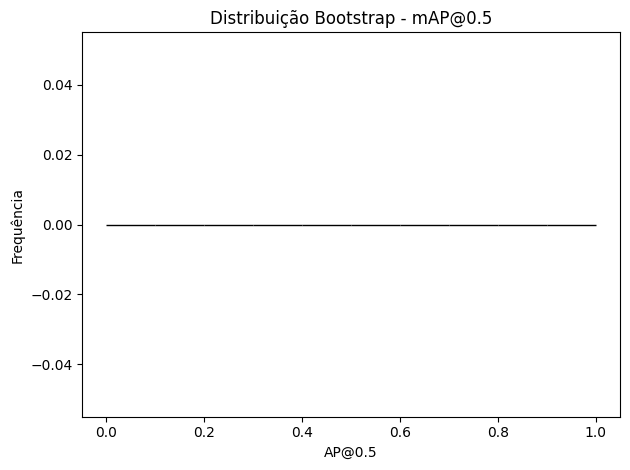

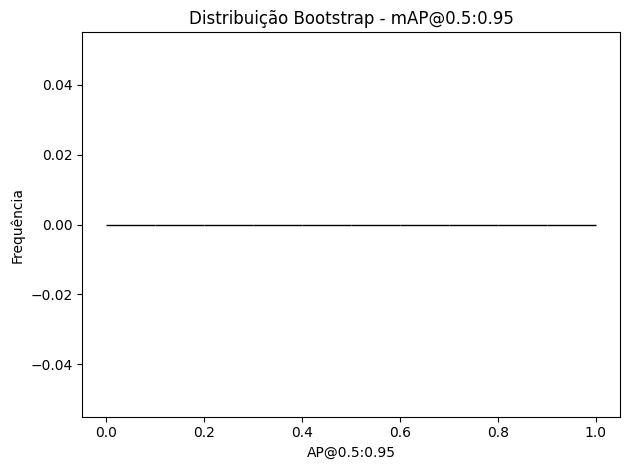

Arquivos salvos em: /content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/runs/bootstrap_test


In [17]:
## BOOTSTRAP (teste com 30 iterações)

!pip install pycocotools

# -*- coding: utf-8 -*-
import json, random, numpy as np
from pathlib import Path
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import yaml, matplotlib.pyplot as plt
import pandas as pd
import time

# ---------------- CONFIG ----------------
ROOT      = Path('/content/drive/MyDrive/Colab Notebooks/Br-AsPavDam')
VAL_LBL   = ROOT/'labels/val'
VAL_IMG   = ROOT/'images/val'
VAL_RUN   = ROOT/'runs/val_repro/br-aspavdam_val_json'
PRED_JSON = VAL_RUN/'best_predictions.json'
CFG_YAML  = ROOT/'config.yaml'
GT_JSON   = VAL_RUN/'best_gt.json'

N_BOOT = 30   # número de iterações do bootstrap (teste)
OUT_DIR = ROOT/'runs/bootstrap_test'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- FUNÇÃO: CONVERTER YOLO -> COCO JSON ----------------
def yolo_to_coco_json(lbl_dir, img_dir, class_names):
    images, annotations = [], []
    ann_id = 1
    for img_id, img_file in enumerate(sorted(img_dir.glob('*.*'))):
        import cv2
        im = cv2.imread(str(img_file))
        if im is None:
            continue
        H,W = im.shape[:2]
        images.append({
            "id": img_id,
            "file_name": img_file.name,
            "height": H,
            "width": W
        })
        lbl_file = lbl_dir/(img_file.stem + ".txt")
        if lbl_file.exists():
            for ln in open(lbl_file):
                parts = ln.strip().split()
                if len(parts) < 5:
                    continue
                c, xc,yc,w,h = parts
                c=int(c); xc,yc,w,h = map(float,(xc,yc,w,h))
                x1,y1 = (xc-w/2)*W, (yc-h/2)*H
                bw,bh = w*W, h*H
                annotations.append({
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": c,
                    "bbox": [x1,y1,bw,bh],
                    "area": bw*bh,
                    "iscrowd": 0
                })
                ann_id+=1

    categories=[{"id":i,"name":n} for i,n in enumerate(class_names)]

    coco_dict = {
        "info": {"description": "YOLO val set converted to COCO", "version": "1.0"},
        "licenses": [],
        "images": images,
        "annotations": annotations,
        "categories": categories
    }
    return coco_dict

# ---------------- PREPARAR GT EM COCO ----------------
with open(CFG_YAML) as f:
    cfg = yaml.safe_load(f)
class_names=[cfg['names'][i] for i in range(len(cfg['names']))]

# sempre recriar o GT_JSON para garantir consistência
coco_dict = yolo_to_coco_json(VAL_LBL, VAL_IMG, class_names)
with open(GT_JSON,"w") as f:
    json.dump(coco_dict,f)

# ---------------- FIXAR PREDICTIONS ----------------
def fix_predictions(pred_json_path, gt_json_path, out_path, score_thr=0.01):
    with open(pred_json_path) as f:
        preds = json.load(f)
    with open(gt_json_path) as f:
        gt = json.load(f)

    # mapa: stem do filename -> id
    imgid_map = {Path(img["file_name"]).stem: img["id"] for img in gt["images"]}

    fixed_preds = []
    for p in preds:
        # usa o nome do arquivo como chave
        img_key = Path(str(p["image_id"])).stem

        if img_key in imgid_map and p.get("score", 1.0) >= score_thr:
            fixed_preds.append({
                "image_id": imgid_map[img_key],
                "category_id": int(p["category_id"]),
                "bbox": [float(x) for x in p["bbox"]],
                "score": float(p["score"])
            })

    with open(out_path, "w") as f:
        json.dump(fixed_preds, f)

    print(f"Predições convertidas salvas em {out_path} ({len(fixed_preds)} entradas)")
    return out_path

FIXED_JSON = VAL_RUN / "best_predictions_fixed.json"
fix_predictions(PRED_JSON, GT_JSON, FIXED_JSON)

# ---------------- DEBUG: conferir primeiros itens ----------------
with open(FIXED_JSON) as f:
    preds_fixed = json.load(f)
print("Exemplo predições corrigidas:", preds_fixed[:3])

# ---------------- BOOTSTRAP ----------------
cocoGt = COCO(str(GT_JSON))
with open(FIXED_JSON) as f:
    preds = json.load(f)
cocoDt = cocoGt.loadRes(preds)

img_ids_all = cocoGt.getImgIds()

ap50, ap5095 = [], []
ap50_classes = {n: [] for n in class_names}
ap5095_classes = {n: [] for n in class_names}

start_time = time.time()

for b in range(N_BOOT):
    sample_ids = random.choices(img_ids_all, k=len(img_ids_all))  # com reposição
    cocoEval = COCOeval(cocoGt, cocoDt, "bbox")
    cocoEval.params.imgIds = sample_ids
    cocoEval.evaluate(); cocoEval.accumulate()

    if cocoEval.stats is not None and len(cocoEval.stats) >= 3:
        ap50.append(cocoEval.stats[0])      # AP@0.5
        ap5095.append(cocoEval.stats[2])    # AP@[.5:.95]
        for i, cls in enumerate(class_names):
            ap50_classes[cls].append(cocoEval.eval['precision'][0, :, i, 0, 2].mean())
            ap5095_classes[cls].append(cocoEval.eval['precision'][:, :, i, 0, 2].mean())
    else:
        ap50.append(np.nan)
        ap5095.append(np.nan)
        for i, cls in enumerate(class_names):
            ap50_classes[cls].append(np.nan)
            ap5095_classes[cls].append(np.nan)

    print(f"[Bootstrap] Iteração {b+1}/{N_BOOT} concluída")

elapsed = time.time() - start_time
print(f"\nTempo total: {elapsed:.1f} segundos")

# ---------------- RESULTADOS ----------------
def summarize(vals, name):
    mean = np.nanmean(vals)
    std  = np.nanstd(vals)
    ci95 = (np.nanpercentile(vals,2.5), np.nanpercentile(vals,97.5))
    print(f"{name}: {mean:.3f} ± {std:.3f} (IC95%: {ci95[0]:.3f} – {ci95[1]:.3f})")
    return {"mean":mean,"std":std,"ci95_low":ci95[0],"ci95_high":ci95[1]}

stats = {
    "mAP@0.5":     summarize(ap50,"mAP@0.5"),
    "mAP@0.5:0.95": summarize(ap5095,"mAP@0.5:0.95")
}

print("\nAP por classe (média de bootstrap):")
class_stats = []
for cls in class_names:
    s50   = summarize(ap50_classes[cls], f"AP@0.5 - {cls}")
    s5095 = summarize(ap5095_classes[cls], f"AP@0.5:0.95 - {cls}")
    class_stats.append({"classe":cls,
                        "AP@0.5_mean":s50["mean"],"AP@0.5_ci95_low":s50["ci95_low"],"AP@0.5_ci95_high":s50["ci95_high"],
                        "AP@0.5:0.95_mean":s5095["mean"],"AP@0.5:0.95_ci95_low":s5095["ci95_low"],"AP@0.5:0.95_ci95_high":s5095["ci95_high"]})

# ---------------- SALVAR CSVs ----------------
df_all = pd.DataFrame({"AP@0.5":ap50,"AP@0.5:0.95":ap5095})
df_all.to_csv(OUT_DIR/"bootstrap_results.csv",index=False)

df_classes = pd.DataFrame(class_stats)
df_classes.to_csv(OUT_DIR/"bootstrap_results_classes.csv",index=False)

# ---------------- HISTOGRAMAS ----------------
plt.hist([x for x in ap50 if not np.isnan(x)], bins=10, color="skyblue", edgecolor="black")
plt.title("Distribuição Bootstrap - mAP@0.5")
plt.xlabel("AP@0.5"); plt.ylabel("Frequência")
plt.tight_layout(); plt.savefig(OUT_DIR/"hist_ap50.png",dpi=200); plt.show()

plt.hist([x for x in ap5095 if not np.isnan(x)], bins=10, color="salmon", edgecolor="black")
plt.title("Distribuição Bootstrap - mAP@0.5:0.95")
plt.xlabel("AP@0.5:0.95"); plt.ylabel("Frequência")
plt.tight_layout(); plt.savefig(OUT_DIR/"hist_ap5095.png",dpi=200); plt.show()

print("Arquivos salvos em:", OUT_DIR)


In [39]:
!python val.py \
    --weights "/content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/runs/train/br-aspavdam_new_labels/weights/best.pt" \
    --data "/content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/config.yaml" \
    --task val \
    --save-json \
    --img 640 \
    --batch 16

val: data=/content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/config.yaml, weights=['/content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/runs/train/br-aspavdam_new_labels/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-432-g725b922e Python-3.12.11 torch-2.8.0+cu126 CPU

Fusing layers... 
Model summary: 362 layers, 88417530 parameters, 0 gradients
100% 755k/755k [00:00<00:00, 13.0MB/s]
val: Scanning /content/drive/MyDrive/Colab Notebooks/Br-AsPavDam/labels/val.cache... 1310 images, 0 backgrounds, 0 corrupt: 100% 1310/1310 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 82/82 [44:30<00:00, 32.57s/it]
                   all       1310       2854      0.807      0.